# Feed-forward сети

Итак, давайте потренируемся тренировать нейронные сети прямого распространения (так как делали на паре)
При этом попробуем создать свою функцию активации на одном из слоев

In [2]:
# Сделаем необходимые импорты
import torch
import torch.nn.functional as F
from torch import optim
from torch import nn

import torchvision.transforms as transforms
import torchvision

import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Загрузим датасет CIFAR-100, сразу же создадим dataloader для него
# Если вам не хватает вычислительных ресурсов, то можно вернуться к CIFAR-10
train_dataset = torchvision.datasets.CIFAR100(root='data/',
                                             train=True,  
                                             transform=transforms.ToTensor(), 
                                             download=True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data/


In [4]:
image, label = train_dataset[0]
print(image.size())
print(label)

torch.Size([3, 32, 32])
19


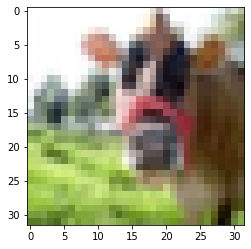

In [5]:
plt.imshow(image.permute(1, 2, 0).numpy());

In [6]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)

In [7]:
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                            download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8,
                                          shuffle=False)

Files already downloaded and verified


In [8]:
classes = ('beaver', 'dolphin', 'otter', 'seal', 'whale', 'aquarium fish', 'flatfish', 'ray', 'shark', 'trout', 'orchids', 'poppies', 'roses', 
           'sunflowers', 'tulips', 'bottles', 'bowls', 'cans', 'cups', 'plates', 'apples', 'mushrooms', 'oranges', 'pears', 'sweet peppers', 	
           'clock', 'computer keyboard', 'lamp', 'telephone', 'television', 'bed', 'chair', 'couch', 'table', 'wardrobe', 'bee', 'beetle', 
           'butterfly', 'caterpillar', 'cockroach', 'bear', 'leopard', 'lion', 'tiger', 'wolf', 'bridge', 'castle', 'house', 'road', 'skyscraper',	
           'cloud', 'forest', 'mountain', 'plain', 'sea', 'camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo', 'fox', 'porcupine', 'possum', 
           'raccoon', 'skunk', 'crab', 'lobster', 'snail', 'spider', 'worm', 'baby', 'boy', 'girl', 'man', 'woman', 'crocodile', 'dinosaur', 'lizard', 
           'snake', 'turtle', 'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel', 'maple', 'oak', 'palm', 'pine', 'willow', 'bicycle', 'bus', 
           'motorcycle', 'pickup truck', 'train', 'lawn-mower', 'rocket', 'streetcar', 'tank', 'tractor')

In [9]:
len(classes)

100

In [10]:
# Создайте собственную архитектуру! Можете использовать все, что угодно, но в ограничении на использование линейные слои (пока без сверток)
# Давайте добавим ограниченный Leaky_relu, то есть output = max(0.1x, 0.5x)
# Ваша задача добавить его в архитектуру сети как функцию активации

In [15]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 8 * hidden_dim)
        self.fc2 = nn.Linear(8 * hidden_dim, 4 * hidden_dim)
        self.fc3 = nn.Linear(4 * hidden_dim, 2 * hidden_dim)
        self.fc4 = nn.Linear(2 * hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        x = F.leaky_relu(x)
        x = self.fc4(x)
        x = F.leaky_relu(x)
        x = self.fc5(x)
        return x
    
    def predict(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        x = F.leaky_relu(x)
        x = self.fc4(x)
        x = F.leaky_relu(x)
        x = self.fc5(x)
        x = F.softmax(x)
        return x


net = Net(3072, 100, 100)
net.train()

Net(
  (fc1): Linear(in_features=3072, out_features=800, bias=True)
  (fc2): Linear(in_features=800, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=100, bias=True)
  (fc5): Linear(in_features=100, out_features=100, bias=True)
)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [17]:
num_epochs = 50

In [18]:
for epoch in range(num_epochs):
    running_loss = 0.0
    running_items = 0.0


    for i, data in enumerate(train_loader):
        inputs, labels = data[0], data[1]

         # Обнуляем градиент
        optimizer.zero_grad()
        # Делаем предсказание
        outputs = net(inputs)
        # Рассчитываем лосс-функцию
        loss = criterion(outputs, labels)
        # Делаем шаг назад по лоссу
        loss.backward()
        # Делаем шаг нашего оптимайзера
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}')
            running_loss, running_items = 0.0, 0.0

print('Training is finished!')

Epoch [1/50]. Step [1/782]. Loss: 0.072
Epoch [1/50]. Step [301/782]. Loss: 0.067
Epoch [1/50]. Step [601/782]. Loss: 0.063
Epoch [2/50]. Step [1/782]. Loss: 0.064
Epoch [2/50]. Step [301/782]. Loss: 0.061
Epoch [2/50]. Step [601/782]. Loss: 0.060
Epoch [3/50]. Step [1/782]. Loss: 0.057
Epoch [3/50]. Step [301/782]. Loss: 0.057
Epoch [3/50]. Step [601/782]. Loss: 0.057
Epoch [4/50]. Step [1/782]. Loss: 0.063
Epoch [4/50]. Step [301/782]. Loss: 0.055
Epoch [4/50]. Step [601/782]. Loss: 0.055
Epoch [5/50]. Step [1/782]. Loss: 0.049
Epoch [5/50]. Step [301/782]. Loss: 0.054
Epoch [5/50]. Step [601/782]. Loss: 0.054
Epoch [6/50]. Step [1/782]. Loss: 0.051
Epoch [6/50]. Step [301/782]. Loss: 0.052
Epoch [6/50]. Step [601/782]. Loss: 0.052
Epoch [7/50]. Step [1/782]. Loss: 0.053
Epoch [7/50]. Step [301/782]. Loss: 0.051
Epoch [7/50]. Step [601/782]. Loss: 0.051
Epoch [8/50]. Step [1/782]. Loss: 0.048
Epoch [8/50]. Step [301/782]. Loss: 0.050
Epoch [8/50]. Step [601/782]. Loss: 0.050
Epoch [9

In [19]:
PATH_WEIGHTS = './cifar_net_test_version_weights.pth'
torch.save(net.state_dict(), PATH_WEIGHTS)

In [20]:
PATH_MODEL = './cifar_net_test_version_model.pth'
torch.save(net, PATH_MODEL)

In [21]:
# Запустить обучение (по аналогии с тем, что делали на паре)

In [22]:
net = Net(3072, 100, 100)
net.load_state_dict(torch.load(PATH_WEIGHTS))
net

Net(
  (fc1): Linear(in_features=3072, out_features=800, bias=True)
  (fc2): Linear(in_features=800, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=100, bias=True)
  (fc5): Linear(in_features=100, out_features=100, bias=True)
)

In [23]:
net = torch.load(PATH_MODEL)

In [24]:
data_iter = iter(test_loader)
images, labels = data_iter.next()

GroundTruth:  skyscraper table girl forest boy motorcycle bottles tulips


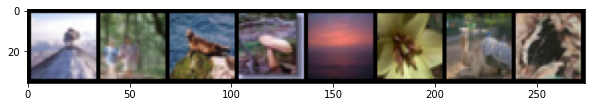

In [25]:
net.eval()
outputs = net(images)
imgs = torchvision.utils.make_grid(images)
plt.figure(figsize=(10, 5))
plt.imshow(imgs.permute(1, 2, 0).numpy())
print('GroundTruth: ', ' '.join(classes[labels[j]] for j in range(len(labels))))

In [26]:
net.predict(images)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[8.5661e-07, 5.5193e-07, 9.6106e-04, 6.3537e-04, 1.4632e-03, 2.1118e-02,
         2.3764e-05, 2.9272e-05, 3.9008e-02, 4.8664e-03, 1.7024e-04, 4.2031e-05,
         1.6984e-01, 4.4861e-04, 3.4656e-08, 1.3099e-03, 1.8155e-02, 4.4114e-02,
         1.9932e-03, 1.3782e-03, 4.7998e-05, 2.0389e-05, 1.0096e-04, 6.7671e-02,
         1.8183e-04, 1.4366e-02, 3.0761e-05, 2.2247e-03, 1.2416e-04, 1.7018e-03,
         3.4554e-03, 2.4357e-03, 1.6437e-03, 1.0143e-03, 2.8150e-05, 7.2144e-05,
         2.0607e-04, 2.8611e-02, 1.9546e-04, 4.3954e-02, 1.5587e-03, 1.1848e-04,
         1.0701e-05, 7.1492e-08, 3.0150e-03, 1.2647e-03, 1.3198e-03, 4.6985e-06,
         2.3569e-03, 6.0174e-02, 1.5360e-03, 5.9652e-07, 2.2693e-06, 3.7804e-09,
         4.0075e-04, 5.4141e-03, 1.3344e-04, 7.8571e-06, 7.5849e-05, 4.5500e-03,
         2.5336e-02, 1.1202e-04, 2.8085e-04, 2.6245e-04, 2.4033e-04, 1.4469e-03,
         3.7340e-04, 4.0917e-03, 8.4315e-03, 6.7689e-02, 1.5593e-03, 1.5487e-01,
         2.8622e-02, 4.7624e

In [27]:
_, predicted = torch.max(outputs, 1)

In [28]:
predicted

tensor([12, 38, 44, 40, 70,  6, 65,  7])

In [29]:
print('Predicted: ', ' '.join(classes[predicted[j]] for j in range(len(labels))))

Predicted:  roses caterpillar wolf bear baby flatfish crab ray


In [30]:
gt = np.array([classes[labels[j]] for j in range(len(labels))])
pred = np.array([classes[predicted[j]] for j in range(len(labels))])

print(gt)
print(pred)
print(f'Accuracy is {(gt == pred).sum() / len(gt)}')

['skyscraper' 'table' 'girl' 'forest' 'boy' 'motorcycle' 'bottles'
 'tulips']
['roses' 'caterpillar' 'wolf' 'bear' 'baby' 'flatfish' 'crab' 'ray']
Accuracy is 0.0
